This notebook replaces the continuous med-only notebook and now contains the development code for building both the continuous and intermittent med admin tables -- since they are sourced from the same MIMIC-IV table, `inputevents`.

# Init

In [1]:
import os
os.chdir("..")
os.getcwd()

'/Users/wliao0504/code/clif/CLIF-MIMIC'

## Import

In [2]:
# src/tables/medication_admin.py
import numpy as np
import pandas as pd
import logging
from importlib import reload
import src.utils
reload(src.utils)
import duckdb
reload(duckdb)
from src.utils import construct_mapper_dict, fetch_mimic_events, load_mapping_csv, \
    get_relevant_item_ids, find_duplicates, rename_and_reorder_cols, save_to_rclif, \
    convert_and_sort_datetime, setup_logging, search_mimic_items, mapping_path_finder
# from fuzzywuzzy import process
import src.tables.medication_admin as med
reload(med)

2025-10-05 19:23:50,093 - INFO - initialized logging at logs/etl.log
2025-10-05 19:23:50,093 - INFO - initialized logging at logs/etl.log


loaded configuration from /Users/wliao0504/code/clif/CLIF-MIMIC/src/../config/config.json
loaded configuration from /Users/wliao0504/code/clif/CLIF-MIMIC/src/../config/config.json


<module 'src.tables.medication_admin' from '/Users/wliao0504/code/clif/CLIF-MIMIC/src/tables/medication_admin.py'>

In [3]:
duckdb_version = duckdb.__version__
print(f"DuckDB version: {duckdb_version}")

DuckDB version: 1.4.0


In [4]:
setup_logging()

MAC_COLUMNS = [
    "hospitalization_id", "med_order_id", "admin_dttm", "med_name", "med_category", "med_group", 
    "med_route_name", "med_route_category", "med_dose", "med_dose_unit", "mar_action_name", "mar_action_category"
]

MAC_COL_RENAME_MAPPER = {
    "dose": "med_dose",
    "rateuom": "med_dose_unit",
    "amountuom": "med_dose_unit",
    "new_mar": "mar_action_name", 
    "linkorderid": "med_order_id",
    "recorded_dttm": "admin_dttm"
}

MAC_MCIDE_URL = "https://raw.githubusercontent.com/clif-consortium/CLIF/main/mCIDE/clif_medication_admin_continuous_med_categories.csv"

def map_name_to_category(name, categories):
    '''
    Map a medication name to a category using fuzzy matching.
    '''
    match, score = process.extractOne(name, categories)
    return match if score >= 80 else None

def are_doses_close(doses):
    return (abs(doses.iloc[0] - doses.iloc[1]) / max(doses.iloc[0], doses.iloc[1])) <= 0.1

# drop the row with the shorter mar_action_name
def drop_shorter_action_name(group):
    if len(group) == 2 and are_doses_close(group['med_dose']):
        return group.loc[[group['mar_action_name'].str.len().idxmax()]]
    return group

2025-10-05 19:23:50,103 - INFO - initialized logging at logs/etl.log


In [5]:
pt_demo = pd.read_parquet('tests/clif_patient.parquet')

# Query MIMIC items

## Intm

In [7]:
med_admin_mapping = load_mapping_csv("med_admin")
current_meds = med_admin_mapping['med_category'].unique()
# Load intm medication categories from GitHub
latest_intm_meds = pd.read_csv("https://raw.githubusercontent.com/clif-consortium/CLIF/main/mCIDE/medication_admin_intermittent/clif_medication_admin_intermittent_med_categories.csv")

new_intm_meds = set(latest_intm_meds.med_category.unique()) - set(current_meds)
new_intm_meds

{'amoxicillin',
 'ampicillin',
 'anidulafungin',
 'caspofungin',
 'cefaclor',
 'cefamandole',
 'cefmetazole',
 'cefonicid',
 'cefoperazone',
 'cefpodoxime',
 'cefprozil',
 'ceftibuten',
 'ceftizoxime',
 'cephalothin',
 'cephapirin',
 'cephradine',
 'cidofovir',
 'cinoxacin',
 'cloxacillin',
 'dalbavancin',
 'delafloxacin',
 'diazepam ',
 'diphenhydramine ',
 'eravacycline',
 'fludrocortisone',
 'foscarnet',
 'ganciclovir',
 'gatifloxacin',
 'hydromorphone ',
 'imipenem_relebactam',
 'isavuconazonium',
 'kanamycin',
 'lefamulin',
 'lincomycin',
 'maribavir',
 'methicillin',
 'mezlocillin',
 'micafungin_posaconazole_voriconazole',
 'minocycline',
 'nafcillin',
 'norfloxacin',
 'ofloxacin',
 'olanzapine ',
 'omadacycline',
 'oritavancin',
 'peramivir',
 'pivampicillin',
 'plazomicin',
 'quinupristin_dalfopristin',
 'rezafungin',
 'rifampin',
 'sulbactam_durlobactam',
 'sulfadiazine',
 'sulfadiazine_trimethoprim',
 'sulfisoxazole',
 'tedizolid',
 'telavancin',
 'telithromycin',
 'ticarcill

In [8]:
list_of_dfs_intm = [search_mimic_items(med) for med in new_intm_meds]

# Merge all dataframes on itemid
new_intm_meds_found = pd.concat(list_of_dfs_intm, ignore_index=True)

2025-10-02 21:48:40,233 - INFO - --------------------------------
2025-10-02 21:48:40,235 - INFO - searching for items with keyword 'hydromorphone ' in column 'label' with case sensitive = False.
2025-10-02 21:48:40,239 - INFO - identified 1 event tables to be separately queried: ['inputevents']
2025-10-02 21:48:40,395 - INFO - Found and concatenated 1 items from across 1 event table(s)
2025-10-02 21:48:40,395 - INFO - --------------------------------
2025-10-02 21:48:40,396 - INFO - searching for items with keyword 'maribavir' in column 'label' with case sensitive = False.
2025-10-02 21:48:40,397 - WARNING - No match for 'maribavir' in column 'label' with case sensitive = False.
2025-10-02 21:48:40,398 - INFO - --------------------------------
2025-10-02 21:48:40,398 - INFO - searching for items with keyword 'rifampin' in column 'label' with case sensitive = False.
2025-10-02 21:48:40,400 - INFO - identified 1 event tables to be separately queried: ['inputevents']
2025-10-02 21:48:40,

In [43]:
# manually check some
df = search_mimic_items("epoprostenol")
df

2025-10-05 21:39:15,753 - INFO - --------------------------------
2025-10-05 21:39:15,756 - INFO - searching for items with keyword 'epoprostenol' in column 'label' with case sensitive = False.
2025-10-05 21:39:15,765 - INFO - identified 2 event tables to be separately queried: ['inputevents', 'procedureevents']
2025-10-05 21:39:15,887 - INFO - Found and concatenated 2 items from across 2 event table(s)


,kw,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances,amountuom_instances,rateuom_instances,ordercategoryname_instances,secondaryordercategoryname_instances,ordercategorydescription_instances
0,epoprostenol,229760,Epoprostenol (Veletri),Epoprostenol (Veletri),inputevents,Medications,ng,Solution,982,"Rate: 0.05, 40.25, 58.14; Amount: 0.0, 1.23, 4.5",mg: 982,"ng/kg/min: 888, mcg/kg/min: 94",01-Drips: 982,02-Fluids (Crystalloids): 982,Continuous Med: 982
0,epoprostenol,229366,Epoprostenol (Inhaled),Epoprostenol (Inhaled),procedureevents,Medications,None,Processes,440,"Min: 1.0, Mean: 6178.76, Max: 58999.0",NaN,NaN,NaN,NaN,NaN


## Cont

In [137]:
med_admin_mapping = load_mapping_csv("med_admin")
current_meds = med_admin_mapping['med_category'].unique()
latest_cont_meds = pd.read_csv("https://raw.githubusercontent.com/Common-Longitudinal-ICU-data-Format/CLIF/refs/heads/main/mCIDE/medication_admin_continuous/clif_medication_admin_continuous_med_categories.csv")
new_cont_meds = set(latest_cont_meds.med_category.unique()) - set(current_meds)
new_cont_meds

{'albumin_infusion',
 'albuterol',
 'alprostadil',
 'baclofen',
 'bivalirudin',
 'bupivacaine',
 'cangrelor',
 'cosyntropin',
 'dextrose_in_water_d5w',
 'ipratropium',
 'isoproterenol',
 'lactated_ringers_solution',
 'liothyronine',
 'nitric_oxide',
 'nitroglycerin',
 'oxytocin',
 'papaverine',
 'phentolamine',
 'pitocin',
 'plasma_lyte',
 'remifentanil',
 'repletion',
 'ropivacaine',
 'sodium chloride',
 'tacrolimus',
 'terbutaline',
 'thyroid replacement',
 'tocolyttics',
 'torsemide',
 'zidovudine'}

In [139]:
list_of_dfs_cont = [search_mimic_items(med) for med in new_cont_meds]

# Merge all dataframes on itemid
cont_meds_found = pd.concat(list_of_dfs_cont, ignore_index=True)

2025-09-11 16:02:54,107 - INFO - searching for items with keyword 'terbutaline' in column 'label' with case sensitive = False.
2025-09-11 16:02:54,111 - WARNING - No match for 'terbutaline' in column 'label' with case sensitive = False.
2025-09-11 16:02:54,112 - INFO - searching for items with keyword 'zidovudine' in column 'label' with case sensitive = False.
2025-09-11 16:02:54,114 - WARNING - No match for 'zidovudine' in column 'label' with case sensitive = False.
2025-09-11 16:02:54,114 - INFO - searching for items with keyword 'tocolyttics' in column 'label' with case sensitive = False.
2025-09-11 16:02:54,116 - WARNING - No match for 'tocolyttics' in column 'label' with case sensitive = False.
2025-09-11 16:02:54,116 - INFO - searching for items with keyword 'cangrelor' in column 'label' with case sensitive = False.
2025-09-11 16:02:54,118 - WARNING - No match for 'cangrelor' in column 'label' with case sensitive = False.
2025-09-11 16:02:54,119 - INFO - searching for items with 

# ETL

In [19]:
dialysis_heparins = fetch_mimic_events([224145])

2025-10-02 23:03:47,229 - INFO - querying the d_items table to identify which event tables to be separately queried for 1 items
2025-10-02 23:03:47,234 - INFO - identified 1 event tables to be separately queried: ['chartevents']
2025-10-02 23:03:47,234 - INFO - fetching events from chartevents table for 1 items
2025-10-02 23:03:48,268 - INFO - fetched 181081 events from chartevents table for 1 items
2025-10-02 23:03:48,269 - INFO - concatenated 181081 events from 1 event table(s)


## Load

In [6]:
med_admin_mapping = load_mapping_csv("med_admin")

logging.info("parsing the mapping files to identify relevant items and fetch corresponding events...")
med_item_ids = get_relevant_item_ids(
    mapping_df = med_admin_mapping, 
    decision_col = "decision", 
    excluded_labels = ["NO MAPPING", "UNSURE", "NOT AVAILABLE"]
    ) 

med_events = fetch_mimic_events(med_item_ids).pipe(convert_and_sort_datetime)

2025-10-05 19:23:55,624 - INFO - parsing the mapping files to identify relevant items and fetch corresponding events...
2025-10-05 19:23:55,627 - INFO - querying the d_items table to identify which event tables to be separately queried for 129 items
2025-10-05 19:23:55,637 - INFO - identified 1 event tables to be separately queried: ['inputevents']
2025-10-05 19:23:55,637 - INFO - fetching events from inputevents table for 129 items
2025-10-05 19:23:55,638 - WARNING - inputevents not yet supported, thus returning all columns
2025-10-05 19:24:00,249 - INFO - fetched 7276916 events from inputevents table for 129 items
2025-10-05 19:24:00,250 - INFO - concatenated 7276916 events from 1 event table(s)


In [7]:
med_events['ordercomponenttypedescription'] = med_events['ordercomponenttypedescription'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [8]:
q = """
SELECT med_category, CAST(itemid AS INT) AS itemid, decision
    , COUNT(*) OVER (PARTITION BY itemid) AS count
    , linksto
FROM med_admin_mapping
WHERE decision in ('BOTH', 'CONTINUOUS', 'INTERMITTENT')
ORDER BY count DESC
"""
med_admin_mapping_c = duckdb.sql(q).df()
med_admin_mapping_c

,med_category,itemid,decision,count,linksto
0,diazepam,221623,INTERMITTENT,2,inputevents
1,diazepam,221623,INTERMITTENT,2,inputevents
2,dextrose,220949,BOTH,2,inputevents
3,dextrose_in_water_d5w,220949,BOTH,2,inputevents
4,vecuronium,222062,BOTH,1,inputevents
...,...,...,...,...,...
126,furosemide,221794,BOTH,1,inputevents
127,norepinephrine,221906,CONTINUOUS,1,inputevents
128,eptifibatide,225151,CONTINUOUS,1,inputevents
129,labetalol,225153,BOTH,1,inputevents


## Relevant columns

### EDA med route

In [9]:
route_mapping = load_mapping_csv("med_route_category")

EDA on med_route: columns to consider:
- [x] `ordercategoryname`
- [x] `secondaryordercategoryname`
- [x] `ordercomponenttypedescription`
- [x] `ordercategorydescription`
- [x] `category`

In [10]:
q = """
SELECT 
    ordercategoryname,
    secondaryordercategoryname,
    ordercomponenttypedescription,
    ordercategorydescription,
    category,
    COUNT(*) AS n
FROM med_events
GROUP BY ordercategoryname, secondaryordercategoryname, ordercomponenttypedescription, ordercategorydescription, category
ORDER BY n DESC
"""
route_combos = duckdb.sql(q).df()

In [11]:
q = """
FROM route_mapping m
LEFT JOIN med_events e
    ON e.ordercategoryname IS NOT DISTINCT FROM m.mimic_ordercategoryname
    AND e.secondaryordercategoryname IS NOT DISTINCT FROM m.mimic_secondaryordercategoryname
    AND e.ordercomponenttypedescription IS NOT DISTINCT FROM m.mimic_ordercomponenttypedescription
    AND e.ordercategorydescription IS NOT DISTINCT FROM m.mimic_ordercategorydescription
    AND e.category IS NOT DISTINCT FROM m.mimic_category
SELECT COLUMNS('mimic_')
    , n_id: n
    , e.label
    , e.itemid
WHERE -- m.status = 'pending'
m.clif_med_route_category = 'UNINFORMATIVE'
"""
pending_events = duckdb.sql(q).df()

In [12]:
len(pending_events)

1

In [13]:
q = """
SELECT COLUMNS('mimic_')
    , n_id
    , label
    , itemid
    , COUNT(*) AS n
FROM pending_events
GROUP BY itemid,label, n_id, mimic_ordercategoryname, mimic_secondaryordercategoryname, mimic_ordercomponenttypedescription, mimic_ordercategorydescription, mimic_category
ORDER BY n_id DESC, n DESC
"""
df = duckdb.sql(q).df()

In [14]:
print("note that there is a 'Bolus' category under statusdescription, which is the MAR action")
med_events.value_counts("statusdescription")

note that there is a 'Bolus' category under statusdescription, which is the MAR action


statusdescription
FinishedRunning    4028120
ChangeDose/Rate    2524653
Stopped             408996
Paused              311841
Bolus                 3305
Reported                 1
Name: count, dtype: int64

In [15]:
print(med_events.value_counts("ordercategoryname", dropna=False))
print("\n--- should non-IV be definitely intermittent?")

ordercategoryname
01-Drips                    3968758
08-Antibiotics (IV)         1172567
05-Med Bolus                 853788
02-Fluids (Crystalloids)     578221
06-Insulin (Non IV)          289224
11-Prophylaxis (Non IV)      163670
03-IV Fluid Bolus            103722
04-Fluids (Colloids)          57376
10-Prophylaxis (IV)           52112
12-Parenteral Nutrition       19554
09-Antibiotics (Non IV)       17924
Name: count, dtype: int64

--- should non-IV be definitely intermittent?


In [16]:
print(med_events.value_counts("ordercategorydescription", dropna=False))


ordercategorydescription
Continuous Med    3968758
Drug Push         2531361
Continuous IV      655151
Bolus              103722
Non Iv Meds         17924
Name: count, dtype: int64


In [17]:
df = med_events.value_counts("ordercomponenttypedescription", dropna=False)
print("\n--- which does not seem relevant")
df


--- which does not seem relevant


ordercomponenttypedescription
Main order parameter    4865782
Mixed solution          2312078
Additives Ampoule         99056
Name: count, dtype: int64

In [18]:
print(med_events.value_counts('secondaryordercategoryname', dropna=False))
print("\n--- which does not seem relevant")

secondaryordercategoryname
02-Fluids (Crystalloids)    5193437
NaN                         1485704
Additive (Crystalloid)       578221
Additives (PN)                19554
Name: count, dtype: int64

--- which does not seem relevant


In [19]:
med_events.value_counts("category", dropna=False)

category
Medications                3738342
Fluids/Intake              2865515
Antibiotics                 598461
Blood Products/Colloids      57376
Nutrition - Parenteral       17222
Name: count, dtype: int64

### Map med route

In [20]:
q = f"""
SELECT CAST(COLUMNS('clif_|mimic_') AS VARCHAR)
FROM '{mapping_path_finder("med_route_category")}' 
"""
med_route_mapping = duckdb.sql(q).df()

In [21]:
med_route_mapping.dtypes

clif_med_route_category                object
mimic_ordercategoryname                object
mimic_secondaryordercategoryname       object
mimic_ordercomponenttypedescription    object
mimic_ordercategorydescription         object
mimic_category                         object
dtype: object

In [22]:
med_events.query('itemid == 222011')['ordercomponenttypedescription'][118]

'Additives Ampoule'

In [23]:
q = f"""
SELECT CAST(COLUMNS('clif_|mimic_') AS VARCHAR)
    , CAST(med_name AS VARCHAR)
    , CAST(med_id AS INT) AS med_id
FROM '{mapping_path_finder("med_route_category_special")}' 
"""
med_route_mapping_by_id = duckdb.sql(q).df()

In [24]:
med_route_mapping_by_id.dtypes

clif_med_route_category                object
mimic_ordercategoryname                object
mimic_secondaryordercategoryname       object
mimic_ordercomponenttypedescription    object
mimic_ordercategorydescription         object
mimic_category                         object
CAST(med_name AS VARCHAR)              object
med_id                                  int32
dtype: object

In [25]:
med_events.dtypes

index                                     int64
subject_id                                int64
hadm_id                                   int64
stay_id                                   int64
caregiver_id                              int64
starttime                        datetime64[us]
endtime                          datetime64[us]
storetime                        datetime64[us]
itemid                                    int64
amount                                  float64
amountuom                                object
rate                                    float64
rateuom                                  object
orderid                                   int64
linkorderid                               int64
ordercategoryname                        object
secondaryordercategoryname               object
ordercomponenttypedescription            object
ordercategorydescription                 object
patientweight                           float64
totalamount                             

In [26]:
q = """
FROM med_events e
LEFT JOIN med_route_mapping m
    ON e.ordercategoryname IS NOT DISTINCT FROM m.mimic_ordercategoryname
    AND e.secondaryordercategoryname IS NOT DISTINCT FROM m.mimic_secondaryordercategoryname
    AND e.ordercomponenttypedescription IS NOT DISTINCT FROM m.mimic_ordercomponenttypedescription
    AND e.ordercategorydescription IS NOT DISTINCT FROM m.mimic_ordercategorydescription
    AND e.category IS NOT DISTINCT FROM m.mimic_category
    AND m.clif_med_route_category NOT IN ('SPECIAL', 'UNINFORMATIVE')
LEFT JOIN med_route_mapping_by_id m2 -- for the 'SPECIAL' cases which require itemid (med_id)-specific mapping
    ON e.ordercategoryname IS NOT DISTINCT FROM m2.mimic_ordercategoryname
    AND e.secondaryordercategoryname IS NULL -- NOT DISTINCT FROM m2.mimic_secondaryordercategoryname
    AND e.ordercomponenttypedescription IS NOT DISTINCT FROM m2.mimic_ordercomponenttypedescription
    AND e.ordercategorydescription IS NOT DISTINCT FROM m2.mimic_ordercategorydescription
    AND e.category IS NOT DISTINCT FROM m2.mimic_category
    AND e.itemid IS NOT DISTINCT FROM m2.med_id
SELECT e.*
    , med_route_category: COALESCE(m.clif_med_route_category, m2.clif_med_route_category)
"""
med_route_mapped = duckdb.sql(q).df()

In [27]:
print(f"len before: {len(med_events)}")
print(f"len after: {len(med_route_mapped)}")
assert len(med_route_mapped) == len(med_events), 'length altered after mapping'
med_route_mapped.value_counts("med_route_category", dropna=False)

len before: 7276916
len after: 7276916


med_route_category
iv         6806098
im          447113
enteral      23705
Name: count, dtype: int64

### ID intm

In [28]:
find_intm_where_clause = """
ordercategoryname = '05-Med Bolus'
    OR ordercategorydescription = 'Drug Push'
    OR ordercategorydescription = 'Bolus'
    OR statusdescription = 'Bolus'
"""

In [31]:
query = f"""
SELECT subject_id, hadm_id
    , starttime, endtime --, storetime
    , linkorderid
    , statusdescription
    , med_category
    , rate, rateuom
    , amount, amountuom
    , patientweight
    , totalamount, totalamountuom, originalamount, originalrate
    , ordercategoryname, ordercategorydescription
    , e.itemid
    , e.label
    , e.med_route_category
    , m.decision AS item_class
    , duration_in_mins: EXTRACT(EPOCH FROM (endtime - starttime)) / 60 
    , duration_1min: CASE WHEN (endtime - starttime) = INTERVAL '1 minute'
        THEN 1 ELSE 0 END 
    -- flags to identify intermittents
    , intm_by_ordercategoryname: CASE WHEN ordercategoryname = '05-Med Bolus'
        THEN 1 ELSE 0 END 
    , intm_by_ordercategorydescription: CASE WHEN ordercategorydescription IN ('Drug Push', 'Bolus')
        THEN 1 ELSE 0 END 
    , intm_by_statusdescription: CASE WHEN statusdescription = 'Bolus'
        THEN 1 ELSE 0 END 
    , to_table: CASE
        WHEN item_class = 'INTERMITTENT'
            OR (item_class = 'BOTH' AND ({find_intm_where_clause})) THEN 'intm'
        WHEN item_class = 'CONTINUOUS'
            OR (item_class = 'BOTH' AND NOT ({find_intm_where_clause})) THEN 'cont'
        END
FROM med_route_mapped e
LEFT JOIN med_admin_mapping_c m
    ON e.itemid = m.itemid
    AND m.decision IN ('BOTH', 'CONTINUOUS', 'INTERMITTENT')
ORDER BY hadm_id, starttime, linkorderid, med_category, endtime
"""
med_selected_and_mapped = duckdb.sql(query).df()
print(f"len before: {len(med_route_mapped)}")
print(f"len after: {len(med_selected_and_mapped)}")
# assert len(med_route_mapped) == len(med_selected_and_mapped), 'length altered after mapping'

len before: 7276916
len after: 8516501


In [36]:
med_selected_and_mapped.value_counts(["med_route_category", 'to_table', 'item_class'], dropna=False)

med_route_category  to_table  item_class  
iv                  cont      BOTH            3806334
                    intm      BOTH            2030584
                    cont      CONTINUOUS      1534942
                    intm      INTERMITTENT     673823
im                  intm      INTERMITTENT     304617
                              BOTH             142496
enteral             intm      INTERMITTENT      17911
                              BOTH               5794
Name: count, dtype: int64

In [32]:
med_selected_and_mapped.value_counts("statusdescription")

statusdescription
FinishedRunning    4698530
ChangeDose/Rate    2942852
Stopped             496465
Paused              375007
Bolus                 3646
Reported                 1
Name: count, dtype: int64

## Continuous

In [34]:
print("ensure there is no NA in column that determines the split")
med_selected_and_mapped.value_counts('to_table', dropna=False)

ensure there is no NA in column that determines the split


to_table
cont    5341276
intm    3175225
Name: count, dtype: int64

In [38]:
query = f"""
SELECT *
FROM med_selected_and_mapped
WHERE to_table = 'cont'
ORDER BY hadm_id, med_category, starttime, endtime, linkorderid
-- ORDER BY hadm_id, starttime, linkorderid, med_category, endtime
"""
cont_only = duckdb.sql(query).df()
len(cont_only)

5341276

### QA the split

RESUME: with QAing the split
- [] build the test case for the cont timestamp flattening?
- [] what about intm time stamps?
- [] mar_action_name -> category

### med_route

In [39]:
cont_only.value_counts(subset=['ordercategoryname', 'ordercategorydescription', 'statusdescription'], dropna=False)

ordercategoryname         ordercategorydescription  statusdescription
01-Drips                  Continuous Med            ChangeDose/Rate      2885070
                                                    FinishedRunning      1056537
02-Fluids (Crystalloids)  Continuous IV             FinishedRunning       401742
01-Drips                  Continuous Med            Stopped               388521
                                                    Paused                337023
02-Fluids (Crystalloids)  Continuous IV             Stopped               102268
04-Fluids (Colloids)      Continuous IV             FinishedRunning        57014
02-Fluids (Crystalloids)  Continuous IV             ChangeDose/Rate        55608
                                                    Paused                 37007
12-Parenteral Nutrition   Continuous IV             FinishedRunning        11371
                                                    Stopped                 5288
                                       

### dose `rate` missing

In [ ]:
query = """
SELECT *
    --, EXTRACT(EPOCH FROM (endtime - starttime)) / 60 AS duration_in_mins
    , amount / duration_in_mins AS rate_imputed
    , CONCAT(amountuom, '/min') AS rateuom_imputed
    , ABS(originalrate - rate_imputed) AS abs_diff
    , abs_diff / ((originalrate + rate_imputed) / 2) AS rel_diff
    , CASE WHEN rel_diff <= 0.01 OR abs_diff <= 0.000000001 THEN 1 ELSE 0 END AS close_rates
    , COALESCE(rate, rate_imputed) AS _rate
    , COALESCE(rateuom, rateuom_imputed) AS _rateuom
FROM cont_only
WHERE rate IS NULL
"""
cont_rate_missing = duckdb.sql(query).df()
print(f"Overall there are {cont_rate_missing.shape[0]} ({cont_rate_missing.shape[0]/cont_only.shape[0] * 100:.1f}%) rows with `rate` missing.")

mask = cont_rate_missing['close_rates'] == 0
print(f"Only {mask.mean() * 100:.1f}% ({mask.sum()}) of the imputed rates (using amount divided by duration) deviate from the `originalrate`.")
print("It seeems safe to use the imputed rates to fill the missing `rate`.")

mask2 = (cont_rate_missing['close_rates'] == 0) & (cont_rate_missing['originalrate'] == 0)
print(f"And {mask2.sum()/mask.sum() * 100:.1f}% ({mask2.sum()}) of the {mask.sum()} deviated cases are caused by a zero `originalrate`, which is odd and does not seem valid.")
cont_rate_missing.value_counts('med_category')

Overall there are 99056 (1.9%) rows with `rate` missing.
Only 7.6% (7528) of the imputed rates (using amount divided by duration) deviate from the `originalrate`.
It seeems safe to use the imputed rates to fill the missing `rate`.
And 98.1% (7388) of the 7528 deviated cases are caused by a zero `originalrate`, which is odd and does not seem valid.


med_category
magnesium             82477
sodium bicarbonate    10203
dextrose               4044
insulin                2245
heparin                  87
Name: count, dtype: int64

### Flatten start-end timestamps to admin_dttm

In [40]:
# check monotonicity
q = """
SELECT *
    , LAG(endtime) OVER (PARTITION BY hadm_id, med_category, linkorderid ORDER BY starttime) AS endtime_prev
    , starttime < endtime_prev AS crossover
FROM cont_only
QUALIFY crossover is True
-- ORDER BY hadm_id, med_category, starttime, endtime, linkorderid
ORDER BY hadm_id, starttime, endtime, linkorderid, med_category
"""
crossovers = duckdb.sql(q).df()
print(f"given there are only {len(crossovers)} cases, we might consider dropping them all")

given there are only 38 cases, we might consider dropping them all


In [22]:
cont_lagged = med._prepare_for_timestamp_flattening(cont_only)

In [23]:
# Check pause #
# find demo data to test
query = """
SELECT *    
FROM cont_lagged
WHERE statusdescription = 'FinishedRunning'
    AND is_last_row = 0
    AND is_first_row = 0
    -- AND subject_id IN (SELECT DISTINCT CAST(patient_id AS INT) FROM pt_demo)
"""
df = duckdb.sql(query).df()

- 'Stopped' for the full sample (i.e. not just the MIMIC demo) would yield zero row, meaning it is not an issue.
- 'Paused' and 'FinishedRunning' both yield results, meaning these are cases we need to hanlde. Unfortunately there are qualifying rows for 'FinishedRunning' in the demo data.

In [24]:
cont_flattened_staging = med._flatten_timestamps_staging(cont_only, "rate")
cont_flattened = med._flatten_timestamps(cont_flattened_staging, "rate")

In [25]:
q = """
SELECT *
    , CASE WHEN med_dose IS NULL THEN 1 ELSE 0 END AS dose_missing
FROM cont_flattened
WHERE mar_action_name = 'Paused' 
    AND subject_id IN (
        SELECT DISTINCT CAST(patient_id AS INT)
        FROM pt_demo
    )
"""
df2 = duckdb.sql(q).df()

BinderException: Binder Error: Referenced column "subject_id" not found in FROM clause!
Candidate bindings: "hospitalization_id"

In [ ]:
longer = cont_only.query("linkorderid == 294375").melt(
    id_vars = [
        "hadm_id", "linkorderid", "med_category", 'rate', 'rateuom', 'statusdescription'
    ],
    value_vars = ["starttime", "endtime"],
    var_name = "time", value_name = "admin_dttm"
).sort_values(["hadm_id", "linkorderid", "med_category", "admin_dttm", "time"])

## Intermittent (New)

In [41]:
query = f"""
SELECT *
FROM med_selected_and_mapped
WHERE to_table = 'intm'
ORDER BY hadm_id, med_category, starttime, endtime, linkorderid
-- ORDER BY hadm_id, starttime, linkorderid, med_category, endtime
"""
intm_only = duckdb.sql(query).df()
len(intm_only)

3175225

In [42]:
intm_only.value_counts(subset=['ordercategoryname', 'ordercategorydescription', 'statusdescription'], dropna=False)

ordercategoryname         ordercategorydescription  statusdescription
08-Antibiotics (IV)       Drug Push                 FinishedRunning      1626140
05-Med Bolus              Drug Push                 FinishedRunning       858555
06-Insulin (Non IV)       Drug Push                 FinishedRunning       289224
11-Prophylaxis (Non IV)   Drug Push                 FinishedRunning       163670
03-IV Fluid Bolus         Bolus                     FinishedRunning       105720
02-Fluids (Crystalloids)  Continuous IV             FinishedRunning        58521
10-Prophylaxis (IV)       Drug Push                 FinishedRunning        52112
09-Antibiotics (Non IV)   Non Iv Meds               FinishedRunning        17924
01-Drips                  Continuous Med            Bolus                   3000
02-Fluids (Crystalloids)  Continuous IV             Stopped                  185
                                                    Bolus                     75
                                       

In [45]:
mg_bolus = intm_only.query("label == 'Magnesium Sulfate (Bolus)' and duration_in_mins <= 180")

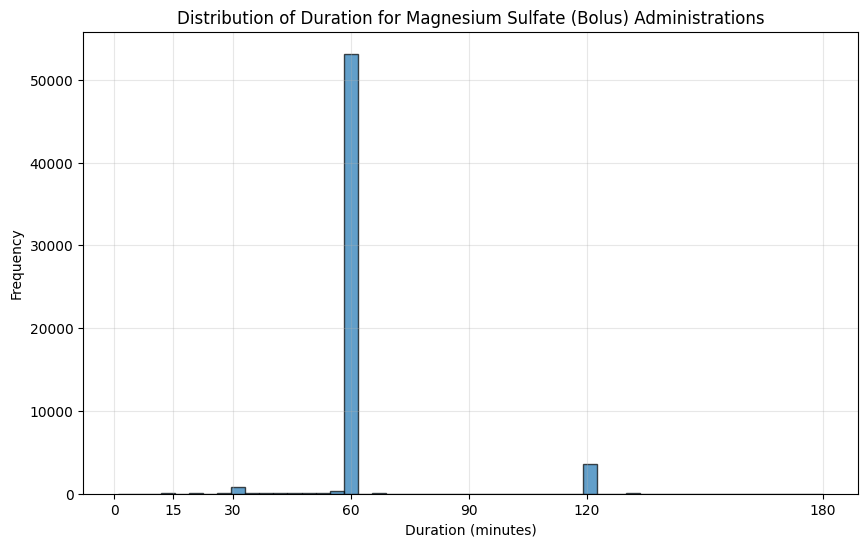

Total records: 58784
Duration statistics:
count    58784.000000
mean        63.094635
std         15.694322
min          1.000000
25%         60.000000
50%         60.000000
75%         60.000000
max        180.000000
Name: duration_in_mins, dtype: float64


In [46]:
import matplotlib.pyplot as plt

# Plot histogram of duration_in_mins for mg_bolus
plt.figure(figsize=(10, 6))
plt.hist(mg_bolus['duration_in_mins'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Duration for Magnesium Sulfate (Bolus) Administrations')

# Mark specific time points on x-axis
plt.xticks([0, 15, 30, 60, 90, 120, 180], ['0', '15', '30', '60', '90', '120', '180'])

#plt.legend()
#plt.xscale('log')
#plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

# Print some summary statistics
print(f"Total records: {len(mg_bolus)}")
print(f"Duration statistics:")
print(mg_bolus['duration_in_mins'].describe())


## Intermittent (Archive)
This part needs updating as it was built to generate cont only without considering keeping intm.

First identify the intermittents and observe their pattern.

In [ ]:
query = f"""
SELECT *
    -- flags to identify intermittents
    , CASE WHEN ordercategoryname = '05-Med Bolus'
        THEN 1 ELSE 0 END AS intm_by_ordercategoryname
    , CASE WHEN ordercategorydescription = 'Drug Push'
        THEN 1 ELSE 0 END AS intm_by_ordercategorydescription
    , CASE WHEN statusdescription = 'Bolus'
        THEN 1 ELSE 0 END AS intm_by_statusdescription
    -- flags to count discrepencies, i.e. if all of the ostensible intermittents satisfy the 1min duration rule
    , CASE WHEN intm_by_ordercategorydescription = 1 AND duration_1min = 0
        THEN 1 ELSE 0 END AS not_1min_ordercategorydescription
    , CASE WHEN intm_by_ordercategoryname = 1 AND duration_1min = 0
        THEN 1 ELSE 0 END AS not_1min_ordercategoryname
    , CASE WHEN intm_by_statusdescription = 1 AND duration_1min = 0
        THEN 1 ELSE 0 END AS not_1min_statusdescription
FROM med_selected_and_mapped
WHERE {find_intm_where_clause}

"""
intm_only = duckdb.sql(query).df()

print(f"# of intermittents identified through ordercategoryname that failed the 1-min rule: {intm_only.not_1min_ordercategoryname.sum()}")
print(f"# of intermittents identified through ordercategorydescription that failed the 1-min rule: {intm_only.not_1min_ordercategorydescription.sum()}")
print(f"# of intermittents identified through statusdescription that failed the 1-min rule: {intm_only.not_1min_statusdescription.sum()}")

# of intermittents identified through ordercategoryname that failed the 1-min rule: 0
# of intermittents identified through ordercategorydescription that failed the 1-min rule: 0
# of intermittents identified through statusdescription that failed the 1-min rule: 1249


From the result it seems `intm_by_statusdescription` is particularly messy, while the other two can be used to safety identify intermittents.

In [ ]:
query = """
SELECT *
FROM intm_only
WHERE not_1min_statusdescription = 1
"""
df = duckdb.sql(query).df()

In [ ]:
# check if any of continuous events has 1-min duration # FIXME: possibly outdated
query = f"""
SELECT *
FROM med_selected_and_mapped
WHERE NOT ({find_intm_where_clause})
"""
intermittent_removed = duckdb.sql(query).df()

In [ ]:
query = f"""
SELECT *
FROM intermittent_removed
WHERE duration_1min = 1
"""
cont_yet_1min = duckdb.sql(query).df()

## Resolve duplicates
This is possibly also outdated as we should now consider duplicate using the linearized time.

In [ ]:
query = """
SELECT *
FROM cont_only
QUALIFY COUNT(*) OVER (PARTITION BY hadm_id, med_category, starttime, statusdescription) > 1
"""
mac_dups = duckdb.sql(query).df()

In [ ]:
# final check there is no dup for god's sake
# mac_ldfd.duplicated(subset=meds_keycols, keep=False).sum()